In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
import numpy as np
from sklearn.datasets.samples_generator import make_blobs
from sklearn.cluster import KMeans

import sys
sys.path.append("../")
from IoTPy.core.stream import Stream, StreamArray, run
from IoTPy.agent_types.sink import sink_window
from examples.K_Means.kmeans import normally_distributed_points

# Part 1: Introduction to Random Points & Plots
This first section is an introduction to generating random points with
a normal distribution with specified centers and standard deviations.
<br>
<br>
This section shows how we generate points around specified centers. Here we have four centers at the four corners of a square. [1.0, 1.0], [1.0, -1.0], [-1.0, -1.0], [-1.0, 1.0]
<br>
<br>
When we compute the centers of clusters using <b>kmeans</b> we find that the centers determined by <b>kmeans</b> are different from the centers used to generate random points.
<br>
<br>
Then we change the points a little, adding some points and taking some points out. The new points that we add are around the specified centers [1.0, 1.0], [1.0, -1.0], ... So the points change but are from the same distribution. We can then look at how the clusters change as points change.
<br>
<br>
As you may expect, if the set of points change by adding a <i>single</i> point and taking out a <i>single</i> point, then the clusters change less than if several points are added and taken out.
<br>
<br>
You can run these programs with different values of standard deviation and see how that impacts changing clusters.
# Part 2: IoTPy
Next we using a sliding window to continuously add and take away points and plot the clusters.

In [2]:
# PRODUCE POINTS IN BLOBS AROUND CENTERS
# centers is the list of centers of the blobs.
CENTERS = np.array([[1.0, 1.0], [1.0, -1.0], 
                    [-1.0, -1.0], [-1.0, 1.0]])
# n_features is the number of features which is also the dimension 
# of the space.
n_features=2
# n_samples is the number of points.
n_samples=20
# cluster_std is the standard deviation of points around the centers.
stdev = 0.2
# Create the points
points, blob_cluster_ids = make_blobs(
    n_samples, n_features, centers=CENTERS, 
    cluster_std=stdev, random_state=0)
# random_state=0 starts random number generator from the same 
# initial value for every run.
# points is the set of points in the blobs
# centers[blob_cluster_ids[i]] is the center that generated points[i]

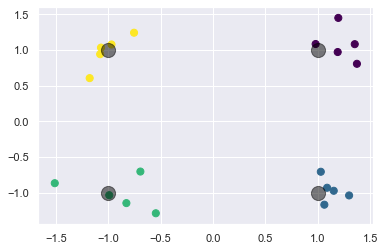

In [3]:
# Plot points where color of a point is associated with 
# the cluster center that generated that point.
plt.scatter(points[:, 0], points[:, 1], 
            c=blob_cluster_ids, s=50, cmap='viridis');
# Plot the centers around which the blobs were generated.
plt.scatter(CENTERS[:, 0], CENTERS[:, 1], c='black', s=200, alpha=0.5);

In [4]:
# Use kmeans to cluster points into n_cluster clusters.
n_clusters = 4
kmeans = KMeans(n_clusters)
kmeans.fit(points)
kmeans_cluster_ids = kmeans.predict(points)
# kmeans_cluster_ids[i] is the id of the cluster associated with points[i]

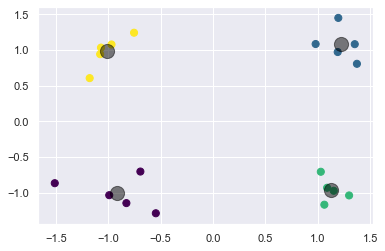

In [5]:
# Plot points where color of a point is determined by 
# the kmeans cluster associated with that point.
# Note that previously we associated the color with 
# the center that generated the point. Now the color is associated
# with the cluster computed using kmeans. 
# The centers of the clusters used to generate points is likely to be
# different from the centers computed by kmeans.
plt.scatter(points[:, 0], points[:, 1], 
            c=kmeans_cluster_ids, s=50, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

In [6]:
# Generate more points around the centers. The number of points
# generated is n_more_points
# Create a sliding window in which n_more_points are generated around
# each center, and the previous n_more_points*n_clusters points are 
# removed.
n_more_points=2
def change_points(points, n_more_points, n_clusters):
    for center in CENTERS:
        # Add more points
        points_around_center = normally_distributed_points(
            center, stdev=stdev, num_points=n_more_points)
        points = np.append(points, points_around_center, axis=0)
    # Remove earlier points.
    points = points[n_more_points*n_clusters:]
    return points
points = change_points(points, n_more_points, n_clusters)

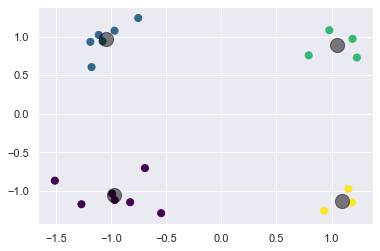

In [7]:
# Use kmeans again to cluster the new set of points.
def clusters_in_moving_windows(points):
    kmeans.fit(points)
    cluster_ids = kmeans.predict(points)
    # Plot the new points with the clusters.
    # Note that the cluster centers may have changed and the
    # clusters may have changed as well.
    plt.scatter(points[:, 0], points[:, 1], c=cluster_ids, 
                s=50, cmap='viridis')
    centers = kmeans.cluster_centers_
    plt.scatter(centers[:, 0], centers[:, 1], c='black', 
                s=200, alpha=0.5);
    plt.show()
clusters_in_moving_windows(points)

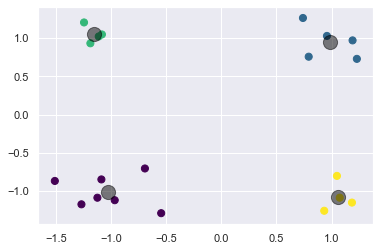

In [8]:
points = change_points(points, n_more_points, n_clusters)
clusters_in_moving_windows(points)

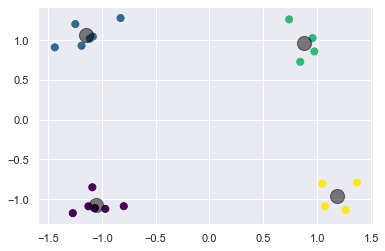

In [9]:
points = change_points(points, n_more_points, n_clusters)
clusters_in_moving_windows(points)

# IoTPy
We use a sliding window to see how clusters change as the set of points changes.

In [14]:
stream_of_points = StreamArray(
    name='stream_of_points', dimension=n_features)

sink_window(func=clusters_in_moving_windows, 
            in_stream=stream_of_points,
            window_size=n_samples,
            step_size=n_more_points*n_clusters);

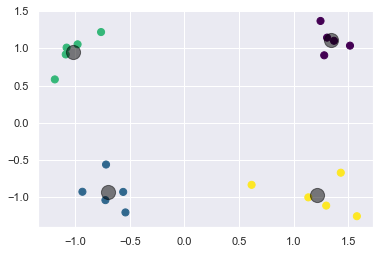

In [12]:
# Start stream
points, blob_cluster_ids = make_blobs(
    n_samples, n_features, centers, cluster_std=stdev, random_state=0)
stream_of_points.extend(points)
run()

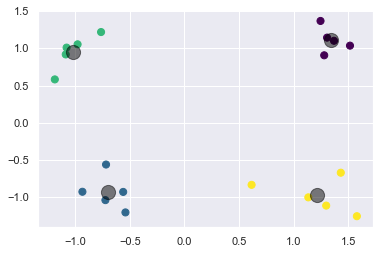

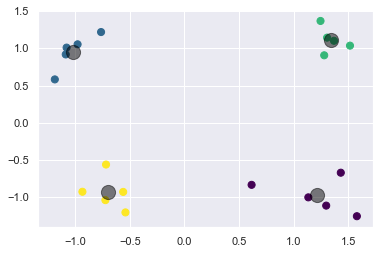

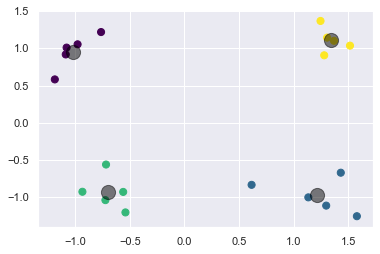

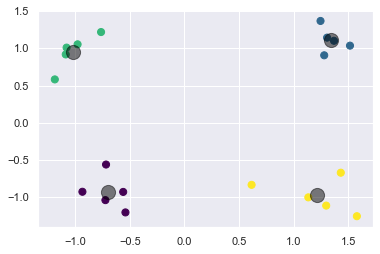

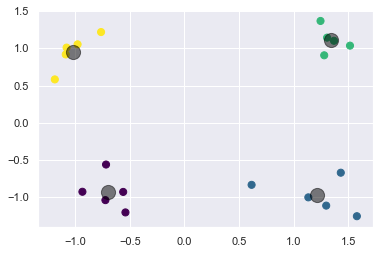

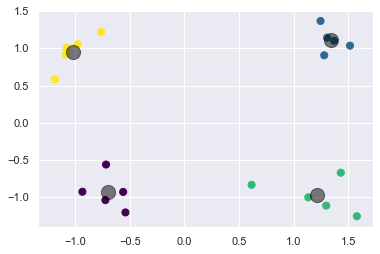

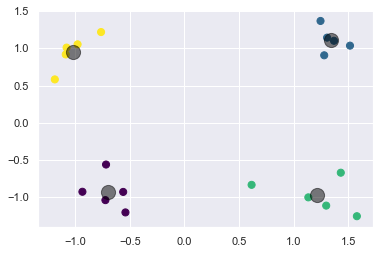

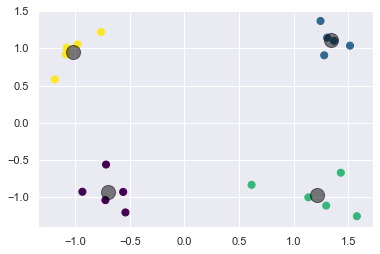

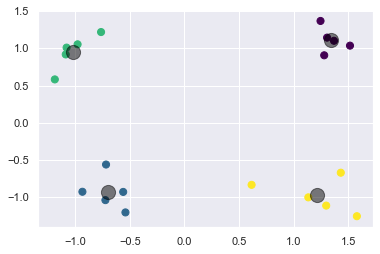

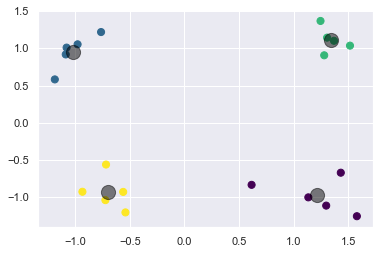

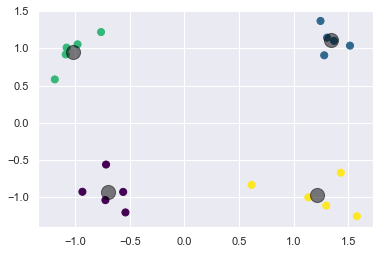

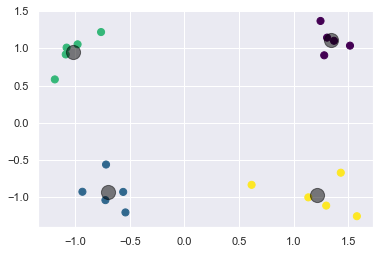

In [13]:
num_steps=5
for i in range(num_steps):
    # Compute points to be added to the stream.
    new_points = np.empty(shape=[0, n_features])
    for center in CENTERS:
        points_around_center = normally_distributed_points(
            center, stdev=stdev, num_points=n_more_points)
        new_points = np.append(new_points, points_around_center, axis=0)
    # Extend the stream with the new points and run.
    stream_of_points.extend(points)
    run()